In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector

from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.primitives import Sampler
from qiskit_finance.applications.estimation.european_call_pricing import EuropeanCallPricing
from qiskit_finance.circuit.library import NormalDistribution


In [27]:
# Set upper and lower data values
bounds = np.array([0.0, 7.0])
# Set number of qubits used in the uncertainty model
num_qubits = 3

# Load the trained circuit parameters
g_params = [0.29399714, 0.38853322, 0.9557694, 0.07245791, 6.02626428, 0.13537225]

# Set an initial state for the generator circuit
init_dist = NormalDistribution(num_qubits, mu=1.0, sigma=1.0, bounds=bounds) # initial state circuit
print(type(init_dist))

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
qc = QuantumCircuit(num_qubits)
qc.h(list(range(num_qubits)))

# construct the variational form
var_form = TwoLocal(num_qubits, "ry", "cz", entanglement="circular", reps=1)
print(type(var_form))

# keep a list of the parameters so we can associate them to the list of numerical values
# (otherwise we need a dictionary)
theta = var_form.ordered_parameters
print(type(theta))

# compose the generator circuit, this is the circuit loading the uncertainty model
g_circuit = qc.compose(var_form)
print(type(g_circuit))

<class 'qiskit_finance.circuit.library.probability_distributions.normal.NormalDistribution'>
<class 'qiskit.circuit.library.n_local.two_local.TwoLocal'>
<class 'list'>
<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


In [28]:
# print(type(init_dist))
# print(init_dist.decompose(reps=3))
print(type(var_form))
print(var_form.decompose())

<class 'qiskit.circuit.library.n_local.two_local.TwoLocal'>
     ┌──────────┐      ┌──────────┐            
q_0: ┤ Ry(θ[0]) ├─■──■─┤ Ry(θ[3]) ├────────────
     ├──────────┤ │  │ └──────────┘┌──────────┐
q_1: ┤ Ry(θ[1]) ├─┼──■──────■──────┤ Ry(θ[4]) ├
     ├──────────┤ │         │      ├──────────┤
q_2: ┤ Ry(θ[2]) ├─■─────────■──────┤ Ry(θ[5]) ├
     └──────────┘                  └──────────┘


In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# set the approximation scaling for the payoff function
c_approx = 0.25


In [5]:
# Evaluate trained probability distribution
values = [
    bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)
]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

print(amplitudes)



[-0.27114733+0.j -0.53967698+0.j -0.46848649+0.j  0.43201978+0.j
 -0.19543144+0.j  0.29751756+0.j  0.24501526+0.j  0.20582655+0.j]


In [6]:
# Sample from target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=1, sigma=1, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 7]
log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal == i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

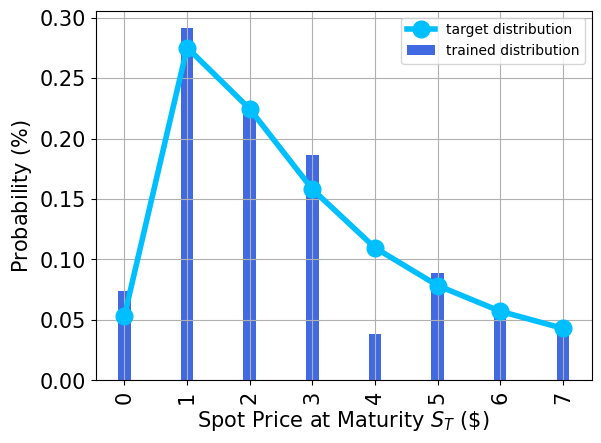

In [7]:
# Plot distributions
plt.bar(x, y, width=0.2, label="trained distribution", color="royalblue")
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.plot(
    log_normal_samples,
    "-o",
    color="deepskyblue",
    label="target distribution",
    linewidth=4,
    markersize=12,
)
plt.legend(loc="best")
plt.show()

Analytically calculated expected payoff w.r.t. the target distribution:  1.0566
Analytically calculated expected payoff w.r.t. the trained distribution: 0.9805


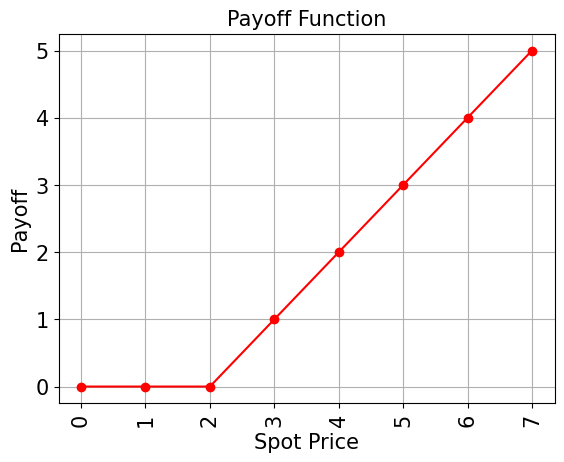

In [8]:
# Evaluate payoff for different distributions
payoff = np.array([0, 0, 0, 1, 2, 3, 4, 5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution:  %.4f" % ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: %.4f" % ep_trained)

# Plot exact payoff function (evaluated on the grid of the trained uncertainty model)
x = np.array(values)
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [9]:
# construct circuit for payoff function
european_call_pricing = EuropeanCallPricing(
    num_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=bounds,
    uncertainty_model=uncertainty_model,
)



In [16]:
epsilon = 0.01
alpha = 0.05

problem = european_call_pricing.to_estimation_problem()


In [19]:
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation

qi = QuantumInstance(backend=AerSimulator(), shots=200)
ae = ModifiedIterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem, shots=100)

/var/folders/1b/41tf8c954h79vyg2kpcm8cqc0000gn/T/ipykernel_49728/2742604586.py:5: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=AerSimulator(), shots=200)


In [17]:
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(options={"shots": 100}))
result = ae.estimate(problem)

In [20]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % ep_trained)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.9805
Estimated value:    	1.0092
Confidence interval:	[0.8933, 1.1251]
